# 小作业三： 夏普利值、梯度上升法与简单多智能体学习算法

同学们此前的课上已经了解了夏普利值与一些经典的多智能体学习算法。在这次作业用，你们将会回顾之前的知识，并用python来加深对这些知识的理解。

## 目录

本次作业主要分为以下几个部分：
- 夏普利值
    - 夏普利值计算
- 矩阵博弈
    - 矩阵博弈环境初始化
    - 梯度上升法之IGA
    - 梯度上升法之WoLF-IGA
    - 梯度上升法之IGA-PP
- 随机博弈
    - 随机博弈环境初始化
    - Q-Learning
    - 多智能体学习算法扩展

## 提交说明：
请同学们在canvas上提交，本次作业满分100分，占总成绩15%。

**注意，请同学们在提交的版本中不要添加和删改notebook中的函数名，我们会根据这些实现的函数来进行评分。如有其他问题，请联系助教。**

提交文件名设置为 `{姓名}_{学号}_hw3.ipynb`，如`小明_123_hw3.ipynb`.


## 夏普利值（共20分）

今有A、B、C三位商人考虑合作完成一系列订单。对于每个订单，A、B、C单干时分别能获利0、0、1万元，A、B合作共能获利6万元，A、C合作共能获利5万元，B、C合作则共能获利3万元。今A、B、C三人共同合作完成了一个订单，一共获利了10万元，按照夏普利的方法，三人该如何分配这10万获利？

为方便表示，各重组合获利情况如下表：
|    联盟 $s$     | $\{A\}$ | $\{B\}$ | $\{C\}$ | $\{A,B\}$ | $\{A,C\}$ | $\{B,C\}$ | $\{A,B,C\}$ |
| :-------------: | :-----: | :-----: | :-----: | :-------: | :-------: | :-------: | :---------: |
| 联盟收益 $v(s)$ |    0    |    0    |    1    |     6     |     5     |     3     |     10      |

根据以上信息，请站在甲的角度，估算甲应分得的利润，并填充以下的表格与 $\psi_A$ （10分）：
|            包含A的联盟             |    $\{A\}$     |   $\{A,B\}$    |   $\{A,C\}$    |  $\{A,B,C\}$   |
| :--------------------------------: | :------------: | :------------: | :------------: | :------------: |
|          联盟收益 $v(s)$           |       0        |       6        |       5        |       10       |
| A的边际贡献 $v(s)-v(s$ \\ $\{A\})$ |       0        |       6        |       4        |       7        |
|          权重系数 $w(s)$           | $\dfrac{1}{3}$ | $\dfrac{1}{6}$ | $\dfrac{1}{6}$ | $\dfrac{1}{3}$ |

A应分得得利润 $\psi_A= 0 \cdot \dfrac{1}{3} + 6 \cdot \dfrac{1}{6} + 4 \cdot \dfrac{1}{6} + 7 \cdot \dfrac{1}{3} = 4$

并补充下面代码中的 `TODO` 部分，用以计算出A、B、C三人各自的应得利润（夏普利值）并填入下表（10分）。
|      商人       |  $A$  |  $B$  |  $C$  |
| :-------------: | :---: | :---: | :---: |
| 夏普利值 $\psi$ |   4   |   3   |   3   |

In [41]:
N_PLAYER = 3
PLAYER_LIST = ['A', 'B', 'C']

V_S = {
    'A': 0,
    'B': 0,
    'C': 1,
    'AB': 6,
    'AC': 5,
    'BC': 3,
    'ABC': 10
}

# 计算边际贡献


def cal_margin(coalition, player):
    ################# TODO #################
    margin = []
    for i in coalition.keys():
        if i.find(player) != -1:
            # print(f"{i} contains {player}")
            value = coalition[i]
            margin_condition = i.replace(player, '')
            if margin_condition == "":
                margin_value = 0
            else:
                margin_value = coalition[margin_condition]
            # print(f"value: {value}, margin_value: {margin_value}, margin_condition: {margin_condition}")
            margin.append(value - margin_value)
        else:
            margin.append(0)
    ############### END TODO ###############
    return margin


# 计算权重系数
def cal_weights(coalition, n_player):
    ################# TODO #################
    import math
    weights = []
    for i in coalition.keys():
        weight = math.factorial(
            len(i) - 1) * math.factorial(n_player - len(i)) / math.factorial(n_player)
        weights.append(weight)
        ############### END TODO ###############
    return weights

# 计算夏普利值


def cal_shapley(n_player, player_list, v_s):
    shapley_value_list = []
    for i in range(n_player):
        ################# TODO #################
        margin = cal_margin(v_s, player_list[i])
        weights = cal_weights(v_s, n_player)
        # print(margin)
        shapley_value = sum(margin[i] * weights[i] for i in range(len(margin)))
        ############### END TODO ###############
        shapley_value_list.append(shapley_value)
    return shapley_value_list


# 测试入口
shapley_values = cal_shapley(N_PLAYER, PLAYER_LIST, V_S)
for i in range(N_PLAYER):
    print("Shapley value for {} is: {}".format(
        PLAYER_LIST[i], shapley_values[i]))


Shapley value for A is: 3.9999999999999996
Shapley value for B is: 3.0
Shapley value for C is: 3.0


## 矩阵博弈（共40分）

#### 初始化矩阵博弈

让我们继续练习一的故事。在合作一段时间后，市场形势发生了巨大的变化，使得后续订单中A与B之间的利益产生了冲突。因此，A与B将重新评估继续参与联盟的可能性并逐渐调整策略。在该过程中，A，B均只有两种可能的动作 $\{1,2\}$，其中 $1$ 代表在下一个订单参与联盟，$2$ 代表不参与。二人不同的联合动作分别对应着各自不同的回报，具体可以用下面的矩阵博弈表示：

$$
\mathbf{R}^A = \left[\begin{matrix}
r^{A}_{11} & r^{A}_{12} \\
r^{A}_{21} & r^{A}_{22}
\end{matrix}\right] = \left[\begin{matrix}
0 & 3 \\
1 & 2
\end{matrix}\right] 
\quad 
\mathbf{R}^B = \left[\begin{matrix}
r^{B}_{11} & r^{B}_{12} \\
r^{B}_{21} & r^{B}_{22}
\end{matrix}\right] = \left[\begin{matrix}
3 & 2 \\
0 & 1
\end{matrix}\right]
\quad 

我们用 $\alpha\in [0,1]$ 来代表A选择动作 $1$ 的概率，用 $\beta\in [0,1]$ 来代表B选择动作 $1$ 的概率。因此，对于给定的联合策略 $(\alpha, \beta)$，我们可以用 $V^A(\alpha, \beta)$ 和 $V^B(\alpha, \beta)$ 来分别表示商人A与B的期望回报：

$$
\begin{aligned} V^{A}(\alpha, \beta) &=\alpha \beta r^A_{11}+\alpha(1-\beta) r^A_{12}+(1-\alpha) \beta r^A_{21}+(1-\alpha)(1-\beta) r^A_{22} \\ &=u^A \alpha \beta+\alpha\left(r^A_{12}-r^A_{22}\right)+\beta\left(r^A_{21}-r^A_{22}\right)+r^A_{22} \end{aligned}
$$
$$
\begin{aligned} V^{B}(\alpha, \beta) &=\alpha \beta r^B_{11}+\alpha(1-\beta) r^B_{12}+(1-\alpha) \beta r^B_{21}+(1-\alpha)(1-\beta) r^B_{22} \\ &=u^B \alpha \beta+\alpha\left(r^B_{12}-r^B_{22}\right)+\beta\left(r^B_{21}-r^B_{22}\right)+r^B_{22}\end{aligned}
$$

其中

$$
\begin{aligned} u^A &=r^A_{11}-r^A_{12}-r^A_{21}+r^A_{22} \\  u^B &=r^B_{11}-r^B_{12}-r^B_{21}+r^B_{22} \end{aligned}
$$

设初始策略 $\alpha = 1.0$ 与 $\beta = 0.1$，补充以下代码的 `TODO` 部分以完成该博弈的初始化（10分）。

In [42]:
import numpy as np
from copy import deepcopy

# 计算u值


def U(payoff):
    ################# TODO #################
    u = payoff[0, 0] - payoff[0, 1] - payoff[1, 0] + payoff[1, 1]
    ############### END TODO ###############
    return u


# 计算给定联合策略下的A或B的期望回报
def V(alpha, beta, payoff):
    u = U(payoff)
    ################# TODO #################
    v = u * alpha * beta + alpha * \
        (payoff[0, 1] - payoff[1, 1]) + beta * \
        (payoff[1, 0] - payoff[1, 1]) + payoff[1, 1]
    ############### END TODO ###############
    return v


# 初始化payoff矩阵
payoff_a = np.array([[0., 3.],
                     [1., 2.]])
payoff_b = np.array([[3., 2.],
                     [0., 1.]])

# 初始策略
pi_alpha = 1.
pi_beta = 0.1

# 纳什均衡策略
################# TODO #################
pi_alpha_nash = 0.5  # nash strategy for player 1
pi_beta_nash = 0.5  # nash strategy for player 2
############### END TODO ###############

u_alpha = U(payoff_a)
u_beta = U(payoff_b)


#### 梯度上升法之 Infinitesimal Gredient Ascent (IGA)

在A与B的磨合过程中，他们先尝试用常见的梯度上升法 [Infinitesimal Gradient Ascent (IGA)](https://www.sciencedirect.com/science/article/pii/S0004370202001212) 来逐步调整各自的策略。在每一次更新策略时，他们都会考虑改变当前策略对期望回报的影响。从数学上理解，该影响可以用期望回报对指定策略的偏微分（梯度）表示，具体如下：

$$
\begin{aligned} \frac{\partial V^{A}(\alpha, \beta)}{\partial \alpha} &=\beta u^A+\left(r^A_{12}-r^A_{22}\right) \\ \frac{\partial V^{B}(\alpha, \beta)}{\partial \beta} &=\alpha u^B+\left(r^B_{21}-r^B_{22}\right). \end{aligned}
$$

更新过程中，A与B均按照所求梯度的方向修改策略以增大期望回报，并考虑利用步长 $\eta$ 来调整策略更新的幅度。设 $(\alpha_k, \beta_k)$ 是在第 $k$ 次更新时的联合策略，IGA的更新过程可以表示为：

$$
\begin{array}{l}{\alpha_{k+1}=\alpha_{k}+\eta \frac{\partial V^{A}\left(\alpha_{k}, \beta_{k}\right)}{\partial \alpha_{k}}} \\ {\beta_{k+1}=\beta_{k}+\eta \frac{\partial V^{B}\left(\alpha_{k}, \beta_{k}\right)}{\partial \beta_{k}}}\end{array}
$$

请根据该过程补充以下代码的 `TODO` 部分，实现IGA的更新过程（10分）。

In [43]:
def IGA(pi_alpha,
        pi_beta,
        payoff_a,
        payoff_b,
        u_alpha,
        u_beta,
        iteration=1000,  # iteration number
        eta=0.01  # step size
        ):
    pi_alpha_history = [pi_alpha]
    pi_beta_history = [pi_beta]
    pi_alpha_gradient_history = [0.]
    pi_beta_gradient_history = [0.]
    for i in range(iteration):
        ################# TODO #################
        pi_alpha_gradient = pi_beta * u_alpha + payoff_a[0, 1] - payoff_a[1, 1]
        pi_beta_gradient = pi_alpha * u_beta + payoff_b[1, 0] - payoff_b[1, 1]
        pi_alpha_next = pi_alpha + eta * pi_alpha_gradient
        pi_beta_next = pi_beta + eta * pi_beta_gradient
        ############### END TODO ###############
        pi_alpha = max(0., min(1., pi_alpha_next))
        pi_beta = max(0., min(1., pi_beta_next))
        pi_alpha_gradient_history.append(pi_alpha_gradient)
        pi_beta_gradient_history.append(pi_beta_gradient)
        pi_alpha_history.append(pi_alpha)
        pi_beta_history.append(pi_beta)
    return pi_alpha_history, \
        pi_beta_history, \
        pi_alpha_gradient_history, \
        pi_beta_gradient_history


#### 梯度上升法之 WoLF-IGA

作为IGA的变种，[WoLF-IGA (Win or Learn Fast)](https://www.sciencedirect.com/science/article/pii/S0004370202001212) 则允许步长 $\eta$ 在更新过程中自适应地改变。我们用 $\alpha^{e}$ 和 $\beta^{e}$ 分别表示A、B商人的纳什均衡策略，则WoLF-IGA的更新过程可以表示为：

$$
\begin{array}{l}{\alpha_{k+1}=\alpha_{k}+\eta_k^{A} \frac{\partial V^{A}\left(\alpha_{k}, \beta_{k}\right)}{\partial \alpha_{k}}} \\ {\beta_{k+1}=\beta_{k}+\eta_k^{B}  \frac{\partial V^{B}\left(\alpha_{k}, \beta_{k}\right)}{\partial \beta_{k}}}\end{array}
$$

其中

$$
\eta_{k}^{A}=\left\{\begin{array}{l}{\eta_{\min } \text { if } V^A\left(\alpha_{k}, \beta_{k}\right)>V^A\left(\alpha^{e}, \beta_{k}\right)} \\ {\eta_{\max } \text { otherwise }}\end{array}\right.
$$

$$
\eta_{k}^{B}=\left\{\begin{array}{l}{\eta_{\min } \text { if } V^B\left(\alpha_{k}, \beta_{k}\right)>V^B\left(\alpha_{k}, \beta^{e}\right)} \\ {\eta_{\max } \text { otherwise }}\end{array}\right.
$$

同样地，完成下面代码中的 `TODO` 部分，以实现WoLF-IGA的更新过程（10分）。

In [44]:
def WoLF_IGA(pi_alpha,
             pi_beta,
             payoff_a,
             payoff_b,
             u_alpha,
             u_beta,
             pi_alpha_nash,
             pi_beta_nash,
             iteration=1000,
             eta_min=0.01,  # min step size
             eta_max=0.04  # max step size
             ):
    pi_alpha_history = [pi_alpha]
    pi_beta_history = [pi_beta]
    pi_alpha_gradient_history = [0.]
    pi_beta_gradient_history = [0.]
    for i in range(iteration):
        ################# TODO #################
        pi_alpha_gradient = pi_beta * u_alpha + payoff_a[0, 1] - payoff_a[1, 1]
        pi_beta_gradient = pi_alpha * u_beta + payoff_b[1, 0] - payoff_b[1, 1]
        eta_a = eta_min if V(pi_alpha, pi_beta, payoff_a) > V(
            pi_alpha_nash, pi_beta, payoff_a) else eta_max
        eta_b = eta_min if V(pi_alpha, pi_beta, payoff_b) > V(
            pi_alpha, pi_beta_nash, payoff_b) else eta_max
        pi_alpha_next = pi_alpha + eta_a * pi_alpha_gradient
        pi_beta_next = pi_beta + eta_b * pi_beta_gradient
        ############### END TODO ###############
        pi_alpha = max(0., min(1., pi_alpha_next))
        pi_beta = max(0., min(1., pi_beta_next))
        pi_alpha_gradient_history.append(pi_alpha_gradient)
        pi_beta_gradient_history.append(pi_beta_gradient)
        pi_alpha_history.append(pi_alpha)
        pi_beta_history.append(pi_beta)
    return pi_alpha_history, \
        pi_beta_history, \
        pi_alpha_gradient_history, \
        pi_beta_gradient_history


#### 梯度上升法之 IGA-PP

上面的两个方法在寻找商人A的新策略 $\alpha_{k+1}$ 时，参考的是商人B在第 $k$ 轮时的策略 $\beta_k$。而 [IGA-PP](https://www.aaai.org/ocs/index.php/AAAI/AAAI10/paper/view/1885) 则尝试对商人B在 $k+1$ 轮时的策略进行预测，并利用预测结果来更新商人A的策略，以寻求更加合理的联合策略 $(\alpha_{k+1}, \beta_{k+1})$。具体过程表示如下：

$$
\begin{array}{l}{\alpha_{k+1}=\alpha_{k}+\eta\frac{\partial V^{A}\left(\alpha_{k}, \beta_{k} + \gamma \partial_{\beta}V^{B}\left(\alpha_{k}, \beta_{k}\right)  \right)}{\partial \alpha_{k}}} \\ {\beta_{k+1}=\beta_{k}+\eta  \frac{\partial V^{B}\left(\alpha_{k} + \gamma \partial_{\alpha} V^{A}\left(\alpha_{k}, \beta_{k} \right) , \beta_{k}\right)}{\partial \beta_{k}}}\end{array}
$$

完成下面代码中的 `TODO` 部分，以实现IGA-PP的更新过程（10分）。

In [45]:
def IGA_PP(pi_alpha,
           pi_beta,
           payoff_a,
           payoff_b,
           u_alpha,
           u_beta,
           iteration=10000,
           eta=0.01,  # step size
           gamma=0.01  # step size for policy prediction
           ):
    pi_alpha_history = [pi_alpha]
    pi_beta_history = [pi_beta]
    pi_alpha_gradient_history = [0.]
    pi_beta_gradient_history = [0.]
    for i in range(iteration):
        ################# TODO #################
        pi_alpha_gradient = u_alpha * pi_beta + u_alpha * pi_alpha * gamma * u_beta + \
            payoff_a[0, 1] - payoff_a[1, 1] + gamma * \
            u_beta * (payoff_a[1, 0] - payoff_a[1, 1])
        pi_beta_gradient = u_beta * pi_alpha + u_beta * pi_beta * gamma * u_alpha + \
            payoff_b[1, 0] - payoff_b[1, 1] + gamma * \
            u_alpha * (payoff_b[0, 1] - payoff_b[1, 1])
        pi_alpha_next = pi_alpha + eta * pi_alpha_gradient
        pi_beta_next = pi_beta + eta * pi_beta_gradient
        ############### END TODO ###############
        pi_alpha = max(0., min(1., pi_alpha_next))
        pi_beta = max(0., min(1., pi_beta_next))
        pi_alpha_gradient_history.append(pi_alpha_gradient)
        pi_beta_gradient_history.append(pi_beta_gradient)
        pi_alpha_history.append(pi_alpha)
        pi_beta_history.append(pi_beta)
    return pi_alpha_history, \
        pi_beta_history, \
        pi_alpha_gradient_history, \
        pi_beta_gradient_history


以下为验证与绘图代码，你可以通过运行以下代码以观察上述三种IGA算法在商人A与B的矩阵博弈中的表现。你可以尝试调整超参（如步长 $\eta$）以了解更多的细节。

In [46]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

FONTSIZE = 12

# Tool to plot the learning dynamics


def plot_dynamics(history_pi_0, history_pi_1, pi_alpha_gradient_history, pi_beta_gradient_history, title=''):
    colors = range(len(history_pi_1))
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)

    scatter = ax.scatter(history_pi_0, history_pi_1, c=colors, s=1)
    ax.scatter(0.5, 0.5, c='r', s=15., marker='*')
    colorbar = fig.colorbar(scatter, ax=ax)
    colorbar.set_label('Iterations', rotation=270, fontsize=FONTSIZE)

    skip = slice(0, len(history_pi_0), 50)
    ax.quiver(history_pi_0[skip],
              history_pi_1[skip],
              pi_alpha_gradient_history[skip],
              pi_beta_gradient_history[skip],
              units='xy', scale=10., zorder=3, color='blue',
              width=0.007, headwidth=3., headlength=4.)

    ax.set_ylabel("Policy of Player 2", fontsize=FONTSIZE)
    ax.set_xlabel("Policy of Player 1", fontsize=FONTSIZE)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_title(title, fontsize=FONTSIZE+8)
    plt.tight_layout()
    plt.show()


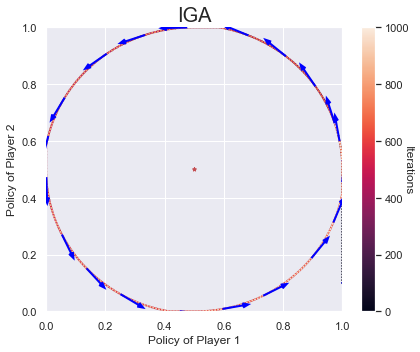

IGA Done


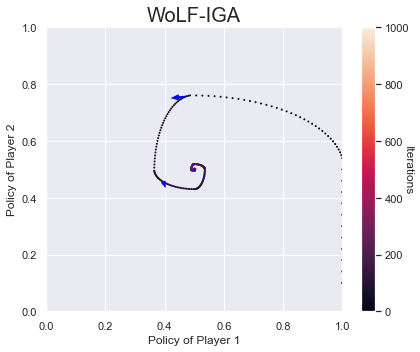

WoLF-IGA Done


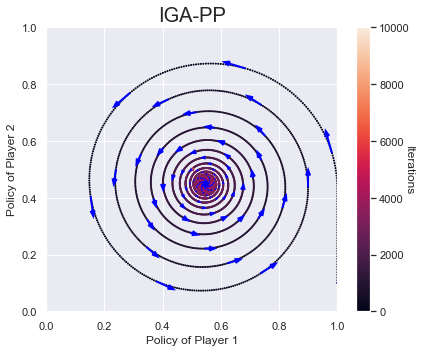

IGA-PP Done


In [47]:
agents = ['IGA', 'WoLF-IGA', 'IGA-PP']

for agent in agents:

    if agent == 'IGA':
        pi_alpha_history, \
            pi_beta_history, \
            pi_alpha_gradient_history, \
            pi_beta_gradient_history = IGA(pi_alpha,
                                           pi_beta,
                                           payoff_a,
                                           payoff_b,
                                           u_alpha,
                                           u_beta,
                                           iteration=1000,  # iteration number
                                           eta=0.01  # step size
                                           )
    elif agent == 'WoLF-IGA':
        pi_alpha_history, \
            pi_beta_history, \
            pi_alpha_gradient_history, \
            pi_beta_gradient_history = WoLF_IGA(pi_alpha,
                                                pi_beta,
                                                payoff_a,
                                                payoff_b,
                                                u_alpha,
                                                u_beta,
                                                pi_alpha_nash=pi_alpha_nash,
                                                pi_beta_nash=pi_beta_nash,
                                                iteration=1000,  # iteration number
                                                eta_min=0.01,  # min step size
                                                eta_max=0.04  # max step size
                                                )

    elif agent == 'IGA-PP':
        pi_alpha_history, \
            pi_beta_history, \
            pi_alpha_gradient_history, \
            pi_beta_gradient_history = IGA_PP(pi_alpha,
                                              pi_beta,
                                              payoff_a,
                                              payoff_b,
                                              u_alpha,
                                              u_beta,
                                              iteration=10000,  # iteration number
                                              eta=0.01,  # step size
                                              gamma=0.025  # step size for policy prediction
                                              )

#   print("pi_alpha_history: ", pi_alpha_history)
    plot_dynamics(pi_alpha_history,
                  pi_beta_history,
                  pi_alpha_gradient_history,
                  pi_beta_gradient_history,
                  agent)
    print('{} Done'.format(agent))


## 随机博弈（共40分）

#### 初始化随机博弈

某天，商人A与B收到了一批未曾接触过的新订单，每一个订单均分为多个不同的步骤，且每个步骤需要A、B二人通力合作才能完成，最终能取得的共同利润也与二人在这些步骤中所做的决策相关。由于A、B此前均无这类订单的经验，他们需要从零开始探索最佳的合作方案，以谋求利润的最大化。

如果我们站在上帝视角，完成新订单的过程可以用下图中的随机博弈表示：
![Stochastic Game](sg.png)
该博弈一共包括5个阶段，其中中间矩阵代表博弈的初始状态，根据二人的联合动作存在着两个分支，分别导向最左最右两个终止阶段。如图所示，除初始与终止状态外，左右两个分支的中间阶段均为连续三次的的重复博弈。A与B均只有两种可能的动作 $\{0,1\}$ （A为行，B为列），且矩阵对应位置的数值代表相应阶段A、B执行联合动作后所共同获得的即时回报，其中的红色标志意味着A、B执行对应联合动作后博弈将提前结束。A、B所获的的总回报为各阶段即时回报之和。

Note：从上帝视角看，不难看出该随机博弈的最优联合动作序列为 $\{(0,0), (0,0), (0,0), (0,0), (1,1)\}$，此时获得的最优总回报为8。但商人A、B并没有上帝视角，他们能观察到的信息仅包括当前所处的阶段与分支。

在这个练习中，同学们需要利用所学的知识，实现属于自己的智能体，以模拟商人A和B探寻最佳合作方案（策略）的过程。 下面是初始化该随机博弈环境的代码，如有需要，环境的细节信息可以从代码中获得。

In [48]:
import numpy as np


class StochasticGame():
    def __init__(self, episode_limit=5, good_branches=2, batch_size=None, **kwargs):
        # Define the agents
        self.n_agents = 2

        self.episode_limit = episode_limit

        # Define the internal state
        self.steps = 0

        r_matrix = [[1, 1], [1, 1]]
        self.payoff_values = [r_matrix for _ in range(self.episode_limit)]
        self.final_step_diff = [[1, 1], [1, 4]]

        self.branches = 4
        self.branch = 0

        self.n_actions = len(self.payoff_values[0])

        self.good_branches = good_branches

    def reset(self):
        """ Returns initial observations and states"""
        self.steps = 0
        self.branch = 0
        return self.get_obs()

    def step(self, actions):
        """ Returns reward, terminated, info """
        current_branch = 0
        if (actions[0], actions[1]) == (0, 0):
            current_branch = 0
        if (actions[0], actions[1]) == (0, 1):
            current_branch = 1
        if (actions[0], actions[1]) == (1, 0):
            current_branch = 2
        if (actions[0], actions[1]) == (1, 1):
            current_branch = 3

        if self.steps == 0:
            self.branch = current_branch

        info = {}

        info["good_payoff"] = 0
        info["branch"] = self.branch

        if self.good_branches == 4:
            reward = 1 if self.branch == current_branch else 0  # Need to follow your branch
        elif self.good_branches == 2:
            reward = 1 if self.branch in [
                0, 3] and self.branch == current_branch else 0
        else:
            raise Exception(
                "Environment not setup to handle {} good branches".format(self.good_branches))

        if self.episode_limit > 1 and self.steps == self.episode_limit - 1 and self.branch == 0:
            info["good_payoff"] = 1
            reward = self.final_step_diff[actions[0]][actions[1]]

        self.steps += 1

        if self.steps < self.episode_limit and reward > 0:
            terminated = False
        else:
            terminated = True

        info["episode_limit"] = False

        # How often the joint-actions are taken
        info["action_00"] = 0
        info["action_01"] = 0
        info["action_10"] = 0
        info["action_11"] = 0
        if (actions[0], actions[1]) == (0, 0):
            info["action_00"] = 1
        if (actions[0], actions[1]) == (0, 1):
            info["action_01"] = 1
        if (actions[0], actions[1]) == (1, 0):
            info["action_10"] = 1
        if (actions[0], actions[1]) == (1, 1):
            info["action_11"] = 1

        return self.get_obs(), [reward] * 2, [terminated] * 2, info

    def get_obs(self):
        """ Returns all agent observations in a list """
        one_hot_step = [0] * (self.episode_limit + 1 + self.branches)
        one_hot_step[self.steps] = 1
        one_hot_step[self.episode_limit + 1 + self.branch] = 1
        return [tuple(one_hot_step) for _ in range(self.n_agents)]

    def get_obs_agent(self, agent_id):
        """ Returns observation for agent_id """
        return self.get_obs()[agent_id]

    def get_obs_size(self):
        """ Returns the shape of the observation """
        return len(self.get_obs_agent(0))

    def get_state(self):
        return self.get_obs_agent(0)

    def get_state_size(self):
        """ Returns the shape of the state"""
        return self.get_obs_size()

    def get_total_actions(self):
        """ Returns the total number of actions an agent could ever take """
        return self.n_actions


#### 随机策略

我们提供了一个简单的随机策略作为基类与例子方便大家了解环境。

In [49]:
from collections import defaultdict
from functools import partial
from abc import ABCMeta, abstractmethod
import random

import numpy as np


def sample(pi):
    return np.random.choice(pi.size, size=1, p=pi)[0]


def normalize(pi):
    minprob = np.min(pi)
    if minprob < 0.0:
        pi -= minprob
    pi /= np.sum(pi)


class BaseQAgent:
    def __init__(self, name, action_num=2, phi=0.01, gamma=0.95, episilon=0.1, **kwargs):
        self.name = name
        self.action_num = action_num
        self.episilon = episilon
        self.gamma = gamma
        self.phi = phi
        self.epoch = 0
        self.Q = None
        self.pi = defaultdict(
            partial(np.random.dirichlet, [1.0] * self.action_num))

    def done(self):
        pass

    def act(self, observation, exploration=False):
        if exploration and random.random() < self.episilon:
            return random.randint(0, self.action_num - 1)
        else:
            return sample(self.pi[observation])

    @abstractmethod
    def update(self, observation, action, reward, next_observation, done):
        pass

    @abstractmethod
    def update_policy(self, observation, action):
        pass


#### Q-Learning

作为马尔可夫决策场景中一个经典的单智能体算法，Q-Learning的策略更新过程可以表示为：

$$
Q(s, a) \leftarrow(1-\phi) Q(s, a)+\phi\left(r+\gamma V\left(s^{\prime}\right)\right)
$$

其中，
$$
V(s)=\max\left(\left[Q(s, a)_{a \in \mathcal{A}}\right]\right)
$$

请同学先尝试着用基于Q-Learning的智能体来解决上面的随机博弈问题，补充下方代码中的 `TODO` 部分（10分）。

In [50]:
class QAgent(BaseQAgent):
    def __init__(self, **kwargs):
        super().__init__('QAgent', **kwargs)
        self.Q = defaultdict(partial(np.random.rand, self.action_num))
        self.R = defaultdict(partial(np.zeros, self.action_num))
        self.count_R = defaultdict(partial(np.zeros, self.action_num))

    def done(self):
        self.R.clear()
        self.count_R.clear()

    def update(self, observation, action, reward, next_observation, done):
        self.count_R[observation][action] += 1.0
        self.R[observation][action] += (reward - self.R[observation]
                                        [action]) / self.count_R[observation][action]
        Q = self.Q[observation]
        V = self.val(next_observation)

        # 请实现Q的更新过程
        ################# TODO #################
        self.Q[observation][action] = (
            1 - self.phi) * Q[action] + self.phi * (reward + self.gamma * V)
        ############### END TODO ###############
        self.update_policy(observation, action)
        self.epoch += 1

    def val(self, observation):
        # 请实现V的计算
        ################# TODO #################
        v = max(self.Q[observation])
        ############### END TODO ###############
        return v

    def update_policy(self, observation, action):
        Q = self.Q[observation]
        self.pi[observation] = (Q == np.max(Q)).astype(np.double)
        self.pi[observation] = self.pi[observation] / \
            np.sum(self.pi[observation])


以下为测试与绘图代码，你可以通过运行以下代码来观察你实现的智能体的表现。

In [51]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy


def rollout(env, agents, exploration=True, max_episode=30000, log_episode_interval=500, verbose=False):
    history_reward = []
    state_n = env.reset()
    episode_reward = 0
    episode_count = 0
    recorded_episodes = []
    recorded_episode_reward = []
    while episode_count < max_episode:
        actions = np.array([agent.act(state, exploration)
                           for state, agent in zip(state_n, agents)])
        next_state_n, reward_n, done_n, _ = env.step(actions)
        episode_reward += np.mean(reward_n)
        for j, (state, reward, next_state, done, agent) in enumerate(zip(state_n, reward_n, next_state_n, done_n, agents)):
            agent.update(state, actions[j], reward, next_state, done)
        state_n = next_state_n
        if np.all(done_n):
            state_n = env.reset()
            history_reward.append(episode_reward)
            episode_reward = 0
            episode_count += 1
            if episode_count % log_episode_interval == 0:
                recorded_episodes.append(episode_count)
                episodes_mean_reward = np.mean(history_reward)
                recorded_episode_reward.append(episodes_mean_reward)
                history_reward = []
                if verbose:
                    print('Episodes {}, Reward {}'.format(
                        episode_count, episodes_mean_reward))
    return recorded_episodes, recorded_episode_reward


In [52]:
agent_num = 2
action_num = 2

runs = 10
log_episode_interval = 500
train_recorded_episodes_log = []
train_recorded_episode_reward_log = []
test_recorded_episode_reward_log = []

for i in range(runs):
    ##################################### INITIALISATION ####################################
    agents = []
    env = StochasticGame()
    for i in range(agent_num):
        agent = QAgent(action_num=action_num)
        agents.append(agent)

    ####################################### TRAINING #######################################
    train_recorded_episodes, train_recorded_episode_reward = rollout(env=env,
                                                                     agents=agents,
                                                                     exploration=True,
                                                                     max_episode=30000,
                                                                     log_episode_interval=log_episode_interval)
    train_recorded_episodes_log.append(train_recorded_episodes)
    train_recorded_episode_reward_log.append(train_recorded_episode_reward)

    ####################################### TESTING #######################################
    test_recorded_episodes, test_recorded_episode_reward = rollout(env=env,
                                                                   agents=agents,
                                                                   exploration=False,
                                                                   max_episode=10,
                                                                   log_episode_interval=1)
    test_recorded_episode_reward_log.append(
        np.mean(test_recorded_episode_reward))


No handles with labels found to put in legend.


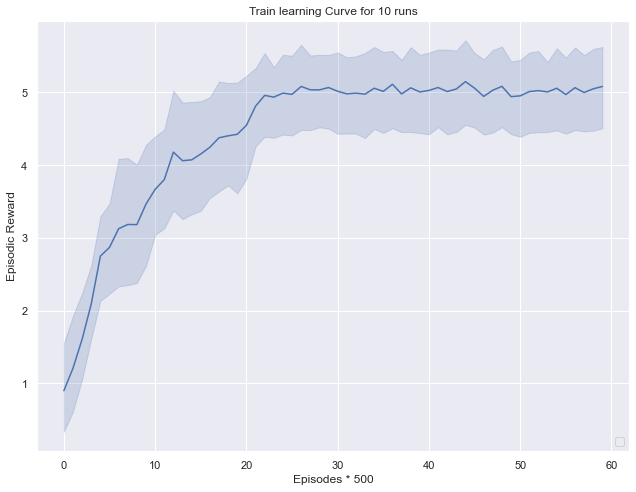

Test reward is (average over 10 runs): 7.1


In [53]:
####################################### TRAINING #######################################
import pandas as pd
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
df_reward = pd.DataFrame(train_recorded_episode_reward_log).melt()
sns.lineplot(ax=ax, x='variable', y='value', data=df_reward)
ax.set_title(f"Train learning Curve for {runs} runs")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes * " + str(log_episode_interval))
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()
####################################### TESTING #######################################
print(f'Test reward is (average over {runs} runs):', np.mean(
    test_recorded_episode_reward_log))


#### 多智能体学习算法扩展

观察Q-Learning的表现，是否有更好的方法去解决这个随机博弈问题呢？实现并训练一个完全属于你的智能体来更好地解决这个问题吧！简单与Q-Learning比较，分析下两种方法的异同与优缺。

Note: 你可能需要考虑一些策略探索的方法。这里列出了一些可供参考的方法，当然，你的选择并不局限于此：
1. [Minimax Q-Learning](https://arxiv.org/abs/1906.06659)
2. [Nash Q-Learning](https://jmlr.csail.mit.edu/papers/volume4/hu03a/hu03a.pdf)
3. [Friend-or-Foe Q-Learning](https://www.researchgate.net/publication/2933305_Friend-or-Foe_Q-learning_in_General-Sum_Games)
4. [WOLF-PHC](https://www.sciencedirect.com/science/article/pii/S0004370202001212)
5. [PGA-APP](https://www.researchgate.net/publication/220269223_Multi-Agent_Learning_with_Policy_Prediction)


请补充下面代码的 `TODO` 部分（20分）。

In [54]:
# 你可以在这里按你的想法实现属于你的智能体！
# 不过请保持接口能跟上面的环境对上，以便验证
################# TODO #################
class MyAgent(BaseQAgent):
    def __init__(self, **kwargs):
        super().__init__('CoolAgent', **kwargs)
        self.Q = defaultdict(partial(np.random.rand, self.action_num))
        self.R = defaultdict(partial(np.zeros, self.action_num))
        self.count_R = defaultdict(partial(np.zeros, self.action_num))
        self.cauchy = 1

    def done(self):
        self.R.clear()
        self.count_R.clear()

    def act(self, observation, exploration=False):
        if exploration and random.random() < self.episilon:
            return random.randint(0, self.action_num - 1)
        else:
            return sample(self.pi[observation])

    # @abstractmethod
    def update(self, observation, action, reward, next_observation, done):
        self.count_R[observation][action] += 1.0
        self.R[observation][action] += (reward - self.R[observation]
                                        [action]) / self.count_R[observation][action]
        self.Q[observation][action] = (1 - self.phi) * self.Q[observation][action] + \
            self.phi * (reward + self.gamma * max(self.Q[next_observation]))
        self.update_policy(observation, action)
        self.epoch += 1

    def val(self, observation):
        return sum(self.Q[observation] * self.pi[observation])

    # @abstractmethod
    def update_policy(self, observation, action):
        for action_i in range(self.action_num):
            if self.pi[observation][action_i] == 1:
                delta_hat = self.Q[observation][action_i] - \
                    self.val(observation)
            else:
                delta_hat = (self.Q[observation][action_i] -
                             self.val(observation)) / (1 - self.pi[observation][action_i])
            delta = delta_hat - self.cauchy * \
                np.abs(delta_hat) * self.pi[observation][action_i]
            self.pi[observation][action_i] += self.phi * delta
            if self.pi[observation][action_i] < 0:
                self.pi[observation][action_i] = 0
            elif self.pi[observation][action_i] > 1:
                self.pi[observation][action_i] = 1
        self.pi[observation] = self.pi[observation] / \
            np.sum(self.pi[observation])
############### END TODO ###############


In [55]:
# 请在这里训练和调试你的智能体，记得最后把你的智能体赋值给test_agents哦
################# TODO #################
agent_num = 2
action_num = 2

runs = 10
log_episode_interval = 500
train_recorded_episodes_log = []
train_recorded_episode_reward_log = []

for i in range(runs):
    # 初始化环境与智能体
    agents = []
    env = StochasticGame()
    for i in range(agent_num):
        agent = MyAgent(action_num=action_num)
        agents.append(agent)

    # 训练智能体
    train_recorded_episodes, train_recorded_episode_reward = rollout(env=env,
                                                                     agents=agents,
                                                                     exploration=True,
                                                                     max_episode=30000,
                                                                     log_episode_interval=log_episode_interval)
    # 保存训练的log
    train_recorded_episodes_log.append(train_recorded_episodes)
    train_recorded_episode_reward_log.append(train_recorded_episode_reward)
    ############### END TODO ###############

    ####################################### TESTING #######################################
    test_agents = agents
    test_recorded_episode_reward_log = []
    # 测试代码，请勿修改
    test_env = StochasticGame()
    test_recorded_episodes, test_recorded_episode_reward = rollout(env=test_env,
                                                                   agents=test_agents,
                                                                   exploration=False,
                                                                   max_episode=10,
                                                                   log_episode_interval=1)
    test_recorded_episode_reward_log.append(
        np.mean(test_recorded_episode_reward))


No handles with labels found to put in legend.


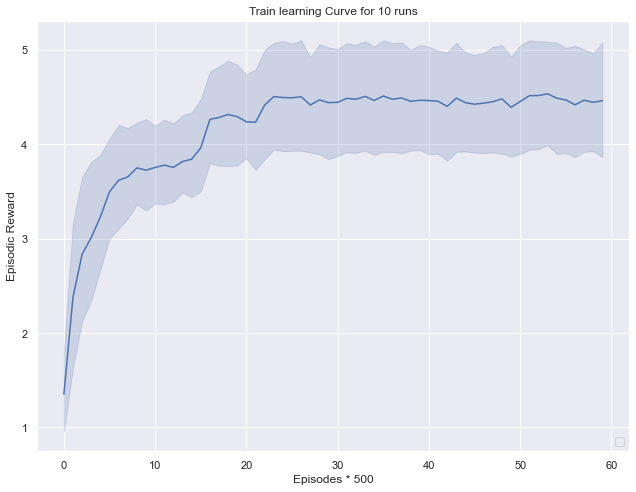

Cool agent's test reward is (average over 10 runs): 8.0


In [56]:
####################################### TRAINING #######################################
import pandas as pd
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
df_reward = pd.DataFrame(train_recorded_episode_reward_log).melt()
sns.lineplot(ax=ax, x='variable', y='value', data=df_reward)
ax.set_title(f"Train learning Curve for {runs} runs")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes * " + str(log_episode_interval))
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f'Cool agent\'s test reward is (average over {runs} runs):', np.mean(
    test_recorded_episode_reward_log))


请在这里简短地描述下你的做法。重点阐述所选算法的核心思路，对比下其与Q-Learning的表现，分析其为何能在表现方面取得提升（小于500字）（10分）。


我使用了`PGA-APP`算法，其主要思想是将`Q-learning`与`IGA-PP`算法进行结合。一方面使用了`Q-Learning`来利用当前奖励更新当前价值，一方面利用 Q 值与 $\pi$ 值进行梯度的计算，来进行策略的更新。

本算法在表现上与`Q-Learning`相对比，从图中可以清楚地看到，`Q-Learning`在训练后达到的average test reward 是 7.1，而本算法在训练后达到的average test reward 是 8.0。考虑到当前博弈环境，最优average test reward 即为 8.0。所以本算法在相同次数的训练后的表现比`Q-Learning`更好。

本算法与`Q-Learning`相对比，主要提升在于：
1. 利用了`IGA-PP`算法的梯度上升思想，兼顾了自己与对方的策略，稳步进行提升。
2. 从某种角度讲，`PGA-APP`算法拓展了`Q-Learning`算法，使得它可以学习混合策略。

本算法与`IGA-PP`相比，主要提升在于：
1. 当策略达到纳什均衡时，梯度为0，不会进行进一步的更新，不影响策略达到纳什均衡的效果。
2. $-\gamma \mid \delta(s,\,a) \mid \pi(s,\,a)$ 的负号是为了模拟$u_r u_c < 0$ 的情况，而这种情况在`IGA-PP`算法中是无法收敛的。这种情况表明了博弈不再是合作博弈，而是竞争博弈。
3. 仅需要观察一个智能体在选择特定动作后的奖励。